In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import ticker
import numpy as np

In [2]:
run = "ck"
run_dir = "/glade/scratch/sturbeville/DPSCREAM_simulations/"
file = run_dir + "scream_dp_RCE_SMALL_3km_{}/run/scream_dp_RCE_SMALL_3km_{}.eam.h0.2000-01-01-00000.nc".format(run,run)
qsmall=0

In [7]:
# vars of interest
# AREI, AWNI, P3_mtend_CLDICE, P3_mtend_NUMICE, P3_ni_nucleat_tend, 
# P3_qc2qi_hetero_frz_tend, P3_sed_CLDICE, P3_qidep
# IWC, CLDICE
ds = xr.open_dataset(file)
print(str((ds.time[-1]-ds.time[0]).values/1e9/3600/24).split(" ")[0]," days")
ds = ds.isel(time=slice(-(67*4)-1, -1))

87  days


In [8]:
def calc_rice(qi, ni, q=ds.Q, p=ds.lev, t=ds["T"]):
    rho = 920 # kg/m3
    qi = qi # kg/kg
    ni =  ni # 1/kg
    r_ice = np.where((qi>1e-9)&(ni>1),(3*qi/(4*np.pi*rho*ni))**(1/3),0)*1e6 # um
    return r_ice

def omega2w(omega, qv, p, t):
    g = 9.8
    w = -omega/(rho(qv,p,t)*g)
    return w


def calc_rhice(ds, varQ="Q", varT="T", z_units="hPa"):
    """ input: xarray with variables Q and T
        output: xarray of rh wrt ice
    """
    e_si = np.exp(9.550426 - 5723.265/ds[varT] \
                  + 3.53068*np.log(ds[varT]) - 0.00728332*ds[varT])
    if z_units=="hPa":
        z = ds.lev*100
    else:
        z=ds.lev
    w_si = (0.622 * e_si) / (z - e_si)
    w_i  = ds[varQ] / (1 - ds[varQ])
    rh_ice = w_i/w_si * 100
    return rh_ice

def calc_rho(qv, p, t):
    """calculates density of air in kg/m3 for given input"""
    R =  287 # (Gas constant of air) J/(kg*K)
    Tv = (1 + 0.61*qv) * t # K
    rho = p / (R*Tv) # kg/m3
    return rho

In [9]:
rice = calc_rice(ds.CLDICE, ds.NUMICE)
rice = xr.DataArray(rice, dims=ds.Q.dims, coords=ds.Q.coords,
            attrs={"long_name":"Mean effective ice radius from eq","units":"um"})
ds = ds.assign({"RICE":rice})

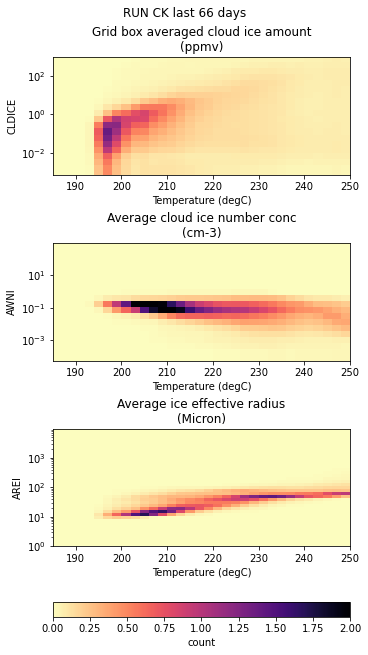

In [12]:
# # # histograms with temperature
var_names = ["CLDICE","AWNI","AREI"] # RICE or AREI
yi = [np.logspace(-3,3,20), np.logspace(-4,3,20), np.logspace(0,4,40)] 
xi = np.arange(180,252,2)
qsmall = 1e-9
rsmall = 1.5/1e6 # micron

fig, ax = plt.subplots(len(var_names),1, figsize=(5,3*len(var_names)), constrained_layout=True)
for i in range(len(var_names)):
    temp_array = ds["T"].values.flatten()
    var_array = ds[var_names[i]].where(ds.CLDICE>qsmall).where(ds[var_names[i]]>0)
    if var_names[i]=="AWNI":
        var_array = var_array/1e6
    elif var_names[i]=="AREI" or var_names[i]=="RICE":
        var_array = var_array.where(ds.AREI>rsmall)
    elif var_names[i]=="CLDICE":
        var_array = var_array*1e6 #g/kg
    var_array = var_array.values.flatten()
    temp_array= temp_array[~np.isnan(var_array)]
    var_array = var_array[~np.isnan(var_array)]
    tot = len(var_array)
    hist, xbins, ybins, _ = stats.binned_statistic_2d(temp_array, var_array, None, 
                                                      statistic="count", bins=[xi, yi[i]])
    xbins = (xbins[1:]+xbins[:-1])/2
    ybins = (ybins[1:]+ybins[:-1])/2
    cf = ax[i].pcolormesh(xbins, ybins, 100*(hist/tot).T, cmap="magma_r", 
                          shading="auto", vmax=2
                        # locator=ticker.LogLocator(), 
                        # vmin=0, vmax=0.1)
                         )

    ax[i].set_ylabel(var_names[i])
    if var_names[i]=="AWNI":
        ax[i].set_title(ds[var_names[i]].long_name+"\n(c"+ds[var_names[i]].units+")")
    elif var_names[i]=="CLDICE":
        ax[i].set_title(ds[var_names[i]].long_name+"\n(ppmv)")
    else:
        ax[i].set_title(ds[var_names[i]].long_name+"\n("+ds[var_names[i]].units+")")
    ax[i].set_yscale("log")
    ax[i].set_xlim([185,250])
    ax[i].grid(True)
    ax[i].set_axisbelow(True)
    ax[i].set_xlabel("Temperature (degC)")
fig.colorbar(cf, ax=ax, label="count", location="bottom")    
fig.suptitle("RUN "+run.upper()+" last {} days".format(str((ds.time[-1]-ds.time[0]).values/1e9/3600/24).split(" ")[0]))
plt.savefig("plots/micro_hist_run_{}-{}-{}_{}.png".format(var_names[0],var_names[1], var_names[2], run))
plt.show()

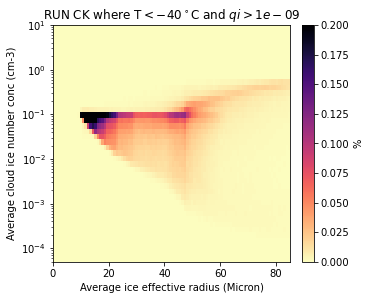

In [11]:
# histograms with var1 and var2
# var_names = ["AWNI","CLDICE"]
# var_names = ["AREI","CLDICE"]
var_names = ["AREI","AWNI"]
fig, ax = plt.subplots(1, 1, figsize=(5,4), constrained_layout=True)
x_array = ds[var_names[0]].where(ds["T"]<243.15).values.flatten() # .where(ds["AWNI"]>0).where(ds["AREI"]>0)
y_array = ds[var_names[1]].where(ds["T"]<243.15).where(ds.CLDICE>qsmall).values.flatten()/1e6 # convert to cm-3
x_array = x_array[~np.isnan(y_array)]
y_array = y_array[~np.isnan(y_array)]
n = len(x_array)
xbins=np.linspace(0,86,100)
ybins=np.logspace(-5,1,50)

hist, xbins, ybins, _ = stats.binned_statistic_2d(x_array, y_array, None, 
                                                  statistic="count", bins=[xbins,ybins])
xbins = (xbins[1:]+xbins[:-1])/2
ybins = (ybins[1:]+ybins[:-1])/2
cf = ax.pcolormesh(xbins, ybins, (hist/n*100).T, cmap="magma_r", 
                   shading='auto',
                   vmin = 0, vmax=0.2 #0.02, 0.3 std
                )
ax.set_yscale("log")
ax.set_xlabel(ds[var_names[0]].long_name+" ("+ds[var_names[0]].units+")")
ax.set_ylabel(ds[var_names[1]].long_name+" (c"+ds[var_names[1]].units+")")
ax.grid(True)
ax.set_axisbelow(True)
fig.colorbar(cf, ax=ax, label="%", location="right", shrink=1)    
ax.set_title("RUN "+run.upper()+" where T$<-40^\circ$C and $qi>{}$".format(qsmall))
ax.set_xlim([0,85])
ax.set_ylim([5e-5,10])
plt.savefig("plots/micro_hist_run_{}-{}_{}.png".format(var_names[0],var_names[1], run), dpi=120)
plt.show()

In [21]:
rhi = rh_ice(ds)
rhi = rhi.assign_attrs({"long_name":"RH wrt ice", "units":"percent"})
ds = ds.assign({"RHICE":rhi})
ds

<xarray.Dataset>
Dimensions:                   (ncol: 1296, lev: 128, ilev: 129, swband: 14, lwband: 16, P3_input_dim: 16, P3_output_dim: 32, time: 161, nbnd: 2)
Coordinates:
  * lev                       (lev) float64 2.58 3.23 3.88 ... 991.0 994.9 998.5
  * ilev                      (ilev) float64 2.255 2.905 3.555 ... 997.0 1e+03
  * swband                    (swband) float64 2.925e+03 3.625e+03 ... 1.71e+03
  * lwband                    (lwband) float64 130.0 375.0 ... 2.965e+03
  * P3_input_dim              (P3_input_dim) int32 1 2 3 4 5 ... 12 13 14 15 16
  * P3_output_dim             (P3_output_dim) int32 1 2 3 4 5 ... 28 29 30 31 32
  * time                      (time) object 2000-01-01 00:00:00 ... 2000-02-1...
Dimensions without coordinates: ncol, nbnd
Data variables: (12/215)
    lat                       (ncol) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    lon                       (ncol) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    area                      (ncol) float64 2.778e+06 6.944e+06 ... 1.736e+07
    hyam                      (lev) float64 0.00258 0.00323 ... 4.618e-05
    hybm                      (lev) float64 0.0 0.0 0.0 ... 0.9907 0.9948 0.9985
    P0                        float64 1e+05
    ...                        ...
    crm_grid_y                (time, ncol) float32 ...
    hstobie_linoz             (time, lev, ncol) float32 ...
    liq_ice_exchange          (time, lev, ncol) float32 ...
    vap_ice_exchange          (time, lev, ncol) float32 ...
    vap_liq_exchange          (time, lev, ncol) float32 ...
    RHICE                     (time, lev, ncol) float64 1.113e-07 ... 63.6
Attributes: (12/19)
    ne:                30
    np:                4
    title:             EAM History file information
    source:            E3SM Atmosphere Model
    source_id:         3791519f92
    product:           model-output
    ...                ...
    institution_id:    E3SM-Project
    institution:       LLNL (Lawrence Livermore National Laboratory, Livermor...
    contact:           e3sm-data-support@listserv.llnl.gov
    initial_file:      /glade/work/sturbeville/E3SM/inputdata/atm/cam/inic/ho...
    topography_file:   /glade/work/sturbeville/E3SM/inputdata/atm/cam/topo/US...
    time_period_freq:  hour_6

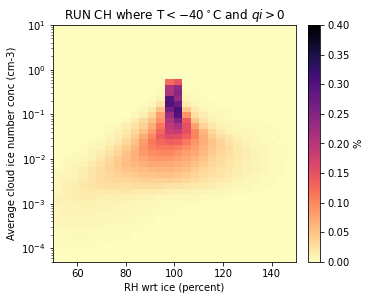

In [61]:
var_names = ["RHICE","AWNI"]
fig, ax = plt.subplots(1, 1, figsize=(5,4), constrained_layout=True)
x_array = ds[var_names[0]].where(ds["T"]<233.15).values.flatten()
y_array = ds[var_names[1]].where(ds["T"]<233.15).where(ds.CLDICE>qsmall).values.flatten()/1e6 # convert to cm-3
x_array = x_array[~np.isnan(y_array)]
y_array = y_array[~np.isnan(y_array)]
xbins=np.linspace(np.min(x_array),np.max(x_array),50)
ybins=np.logspace(-5,1,50)
n = len(x_array)

hist, xbins, ybins, _ = stats.binned_statistic_2d(x_array, y_array, None, 
                                                  statistic="count", bins=[xbins,ybins])
xbins = (xbins[1:]+xbins[:-1])/2
ybins = (ybins[1:]+ybins[:-1])/2
cf = ax.pcolormesh(xbins, ybins, (hist/n*100).T, cmap="magma_r", 
                   shading="auto", vmax=0.4
                    # locator=ticker.LogLocator(), 
                    # levels=np.logspace(0,6,7)
                )
ax.set_yscale("log")
ax.set_xlabel("RH wrt ice (percent)")
ax.set_ylabel(ds[var_names[1]].long_name+" (c"+ds[var_names[1]].units+")")
ax.grid(True)
ax.set_axisbelow(True)
fig.colorbar(cf, ax=ax, label="%", location="right", shrink=1)    
ax.set_title("RUN "+run.upper()+" where T$<-40^\circ$C and $qi>{}$".format(qsmall))
ax.set_xlim([50,150])
ax.set_ylim([5e-5,10])
plt.savefig("plots/micro_hist_run_{}-{}_{}_1A.png".format(var_names[0],var_names[1], run), dpi=120)
plt.show()

In [30]:
# w = omega2w(ds.OMEGA, ds.Q, ds.lev*100, ds["T"])
# w.plot.hist(bins=np.linspace(-2,2,20))
# plt.show()

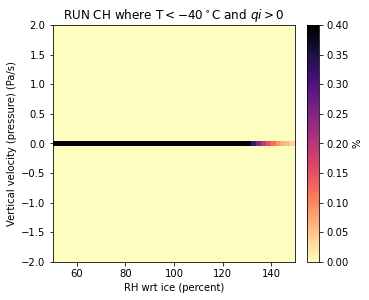

In [30]:
var_names = ["RHICE","OMEGA"]
fig, ax = plt.subplots(1, 1, figsize=(5,4), constrained_layout=True)
x_array = ds[var_names[0]].where(ds["T"]<233.15).values.flatten()
y_array = ds[var_names[1]].where(ds["T"]<233.15).where(ds.CLDICE>qsmall).values.flatten() 
x_array = x_array[~np.isnan(y_array)]
y_array = y_array[~np.isnan(y_array)]
xbins=np.linspace(50,150,50)
ybins=np.linspace(-2,2,50)
n = len(x_array)

hist, xbins, ybins, _ = stats.binned_statistic_2d(x_array, y_array, None, 
                                                  statistic="count", bins=[xbins,ybins])
xbins = (xbins[1:]+xbins[:-1])/2
ybins = (ybins[1:]+ybins[:-1])/2
cf = ax.pcolormesh(xbins, ybins, (hist/n*100).T, cmap="magma_r", 
                   shading="auto", vmax=0.4
                    # locator=ticker.LogLocator(), 
                    # levels=np.logspace(0,6,7)
                )
# ax.set_yscale("log")
ax.set_xlabel("RH wrt ice (percent)")
ax.set_ylabel(ds[var_names[1]].long_name+" ("+ds[var_names[1]].units+")")
ax.grid(True)
ax.set_axisbelow(True)
fig.colorbar(cf, ax=ax, label="%", location="right", shrink=1)    
ax.set_title("RUN "+run.upper()+" where T$<-40^\circ$C and $qi>{}$".format(qsmall))
ax.set_xlim([50,150])
ax.set_ylim([-2,2])
plt.savefig("plots/micro_hist_run_{}-{}_{}.png".format(var_names[0],var_names[1], run), dpi=120)
plt.show()

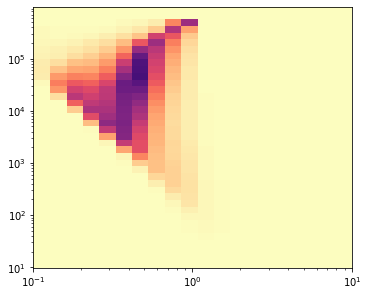

In [29]:
var_names = ["RICE","AWNI"]
fig, ax = plt.subplots(1, 1, figsize=(5,4), constrained_layout=True)
x_array = ds[var_names[0]].where(ds["T"]<233.15).values.flatten()
y_array = ds[var_names[1]].where(ds["T"]<233.15).where(ds.CLDICE>qsmall).values.flatten() 
x_array = x_array[~np.isnan(y_array)]
y_array = y_array[~np.isnan(y_array)]
ybins=np.logspace(1,6,40)
xbins=np.logspace(-2,3,40)
# xbins, ybins = 40,40
n = len(x_array)

hist, xbins, ybins, _ = stats.binned_statistic_2d(x_array, y_array, None, 
                                                  statistic="count", bins=[xbins,ybins])
xbins = (xbins[1:]+xbins[:-1])/2
ybins = (ybins[1:]+ybins[:-1])/2
cf = ax.pcolormesh(xbins, ybins, (hist/n*100).T, cmap="magma_r", 
                   shading="auto", vmax=0.4
                    # locator=ticker.LogLocator(), 
                    # levels=np.logspace(0,6,7)
                )
ax.set_xlim([1e-2,10])
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("R_ice calculated")
ax.set_ylabel("AWNI (")
# ax.grid(True)
# ax.set_axisbelow(True)
# fig.colorbar(cf, ax=ax, label="%", location="right", shrink=1)    
# ax.set_title("RUN "+run.upper()+" where T$<-40^\circ$C and $qi>{}$".format(qsmall))
# ax.set_xlim([50,150])
# ax.set_ylim([-2,2])
# plt.savefig("plots/micro_hist_run_{}-{}_{}.png".format(var_names[0],var_names[1], run), dpi=120)
plt.show()